## SVD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse
import sklearn.manifold

import time
from underrate import *

## load data

In [2]:
dRatings = loadRatings("data/data.txt")
dTrain = loadRatings("data/train.txt", dRatings.shape)
dTest = loadRatings("data/test.txt", dRatings.shape)

dUsers = pd.DataFrame(index=dRatings.index)
dMovies, dGenres = loadMovies("data/movies.txt")

nUsers = dUsers.shape[0]
nRatings = dRatings.shape[0]
nMovies = dMovies.shape[0]
nGenres = dGenres.shape[1]

In [3]:
stats = ratingStats(dRatings)
dMovies = pd.concat([dMovies, stats[1]], axis=1)
dUsers = pd.concat([dUsers, stats[0]], axis=1)

In [4]:
def errplot(E_in, E_out):
    plt.plot(Ks, E_in, label='$E_{in}$')
    plt.plot(Ks, E_out, label='$E_{out}$')
    plt.title('Error vs. K')
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.legend()

## unbiased

In [5]:
def err_unbiased(ratings, U, V, reg=0.0, N=None):
    """
    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    N = N if N else (~np.isnan(dRatings.values)).sum()
    r = .5 * reg / N * (np.sum(np.square(U)) + np.sum(np.square(V))) if reg else 0
    return np.nanmean(np.square(ratings.values - np.matmul(U, V.T)))

In [6]:
def train_unbiased(ratings, K, eta, reg, eps=0.0001, max_epochs=300):
    """
    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSEs
    of the model.
    """
    n_users, n_movies = ratings.shape
    users_i, movies_i = (~np.isnan(ratings.values)).nonzero()
    n_ratings = len(users_i)
    ratings_ = ratings.values
    U = np.random.rand(n_users, K) - 0.5
    V = np.random.rand(n_movies, K) - 0.5
    eprev = err_unbiased(ratings, U, V)
    reduction0 = 1
    for epoch in range(max_epochs):
        for i in np.random.permutation(n_ratings):
            user, movie = users_i[i], movies_i[i]
            rating = ratings_[user, movie]
            Ui, Vj = U[user], V[movie]
            # calculate gradients at once
            err = rating - np.dot(Ui, Vj)
            gU = reg * Ui - Vj * err
            gV = reg * Vj - Ui * err
            # before descending
            U[user] -= eta * gU
            V[movie] -= eta * gV
        e = err_unbiased(ratings, U, V)
        # stopping conditions
        reduction = eprev - e
        reductionratio = reduction / reduction0
        print("epoch", epoch, eprev, reductionratio)
        if (epoch == 0):
            reduction0 = reduction
        if (reductionratio < eps):
            break
        eprev = e
    print("trained epochs:", epoch, reduction)
    return U, V, e

In [7]:
reg = 0.05
eta = 0.03 # learning rate
K = 20

# Use to compute Ein and Eout
start = time.time()
unbiased = train_unbiased(dTrain, K, eta, reg)

ein = err_unbiased(dTrain, *unbiased)
eout = err_unbiased(dTest, *unbiased)
print("elapsed", time.time() - start)

print("Ein", ein, "Eout", eout)

epoch 0 13.851729734228378 12.86647816089661
epoch 1 0.9852515733317679 0.013081032063570718
epoch 2 0.816944759963847 0.00529870998998761
epoch 3 0.7487690235967467 0.004688607807045286
epoch 4 0.6884431536423892 0.003047789866092986
epoch 5 0.6492288318913018 0.0023059489979185568
epoch 6 0.6195593894694412 0.0025486147769064526
epoch 7 0.586767693101836 0.0016631542181896406
epoch 8 0.5653687556752959 0.0015331074861658829
epoch 9 0.5456430616862354 0.0014457264082650132
epoch 10 0.5270416544276622 0.000809582753252389
epoch 11 0.5166251756135017 0.0007306575397698451
epoch 12 0.5072241863349586 0.0007082607884418205
epoch 13 0.4981113643682525 0.0007376853094133387
epoch 14 0.4886199524450715 0.0007659969433680896
epoch 15 0.4787642695019124 0.00027368697269333005
epoch 16 0.4752428820448318 0.000635413782270867
epoch 17 0.46706734449211096 0.0005165235391549237
epoch 18 0.4604215056559851 2.9011125039587297e-05
trained epochs: 18 0.0003732710067448908
elapsed 31.355764627456665
Ei

## biased

In [8]:
def err_biased(ratings, U, V, A, B, mu, reg=0.0, N=None):
    """
    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    N = N if N else (~np.isnan(dRatings.values)).sum()
    r = .5 * reg / N * (np.sum(np.square(U)) + np.sum(np.square(V)) + np.sum(np.square(A)) + np.sum(np.square(B))) if reg else 0
    pred = mu + np.matmul(U, V.T) + np.reshape(A, (-1,1)) + B
    return np.nanmean(np.square(ratings.values - pred))

def train_biased(ratings, K, eta, reg, eps=0.0001, max_epochs=300):
    """
    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSEs
    of the model.
    """
    n_users, n_movies = ratings.shape
    users_i, movies_i = (~np.isnan(ratings.values)).nonzero()
    mu = np.nanmean(ratings.values)
    n_ratings = len(users_i)
    ratings_ = ratings.values
    U = np.random.rand(n_users, K) - 0.5
    V = np.random.rand(n_movies, K) - 0.5
    A = ratings.mean(axis=1).values
    B = ratings.mean(axis=0).values
    eprev = err_biased(ratings, U, V, A, B, mu)
    reduction0 = 1
    for epoch in range(max_epochs):
        for i in np.random.permutation(n_ratings):
            user, movie = users_i[i], movies_i[i]
            rating = ratings_[user, movie]
            Ui, Vj, Ai, Bj = U[user], V[movie], A[user], B[movie]
            # calculate gradients at once
            err = rating - (mu + np.dot(Ui, Vj) + A[user] + B[movie])
            gU = reg * Ui - Vj * err
            gV = reg * Vj - Ui * err
            gA = reg * Ai - err
            gB = reg * Bj - err
            # before descending
            U[user] -= eta * gU
            V[movie] -= eta * gV
            A[user] -= eta * gA
            B[movie] -= eta * gB
        e = err_biased(ratings, U, V, A, B, mu)
        # stopping conditions
        reduction = eprev - e
        reductionratio = reduction / reduction0
        print("epoch", epoch, eprev, reductionratio)
        if (epoch == 0):
            reduction0 = reduction
        if (reductionratio < eps):
            break
        eprev = e
    print("trained epochs:", epoch, reduction)
    return U, V, A, B, mu

In [9]:
reg = 0.05
eta = 0.03 # learning rate
K = 20

# Use to compute Ein and Eout
start = time.time()
biased = train_biased(dTrain, K, eta, reg)

ein = err_biased(dTrain, *biased)
eout = err_biased(dTest, *biased)
print("elapsed", time.time() - start)

print("Ein", ein, "Eout", eout)

epoch 0 50.84406588948461 49.71970964197234
epoch 1 1.1243562475122777 0.006052179674243413
epoch 2 0.8234436314078485 0.0017974558217532341
epoch 3 0.7340746498560049 0.0011144587529490122
epoch 4 0.6786640842514254 0.000987806798695054
epoch 5 0.6295506170379411 0.0007660746671417694
epoch 6 0.5914616070235817 0.0006271777960661781
epoch 7 0.5602785091092792 0.0005133369299262397
epoch 8 0.5347555460048451 0.0004591896477212171
epoch 9 0.5119247700495466 0.0003216732800176676
epoch 10 0.4959312679674873 0.00030817169776685703
epoch 11 0.48060906063464554 0.00026360743984288847
epoch 12 0.46750257526619343 0.00023304729903923774
epoch 13 0.45591553122511663 0.0001489953237156981
epoch 14 0.44850752699196045 0.000172374455925059
epoch 15 0.43993711909367356 0.00015161431754620247
epoch 16 0.4323988992477106 0.00010233048949692598
epoch 17 0.4273110570224025 0.00013092407919063542
epoch 18 0.42080154981990153 9.27226833364431e-05
trained epochs: 18 0.004610144892712498
elapsed 37.559034

## visualize

In [10]:
tsneMovies = sklearn.manifold.TSNE(n_components=2).fit_transform(biased[1])
print(tsneMovies.shape)

(1682, 2)


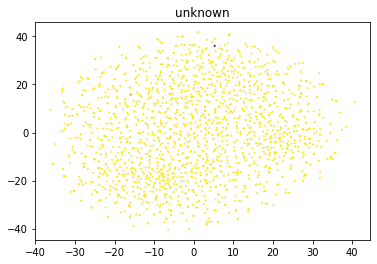

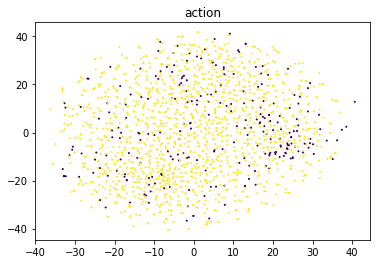

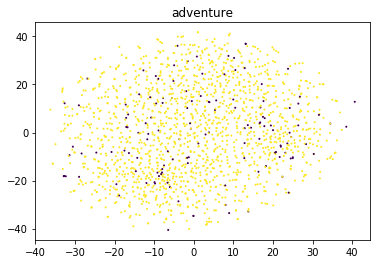

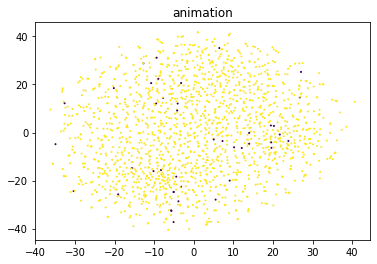

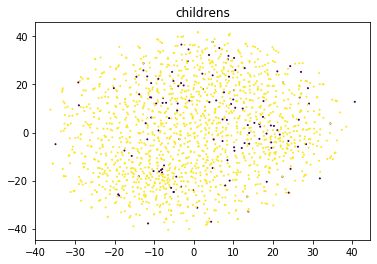

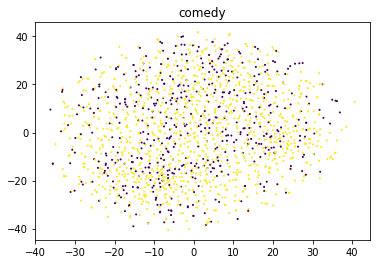

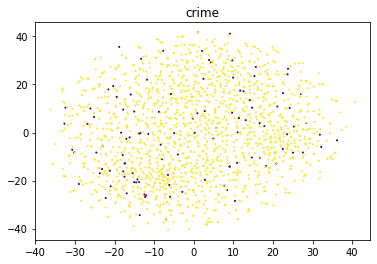

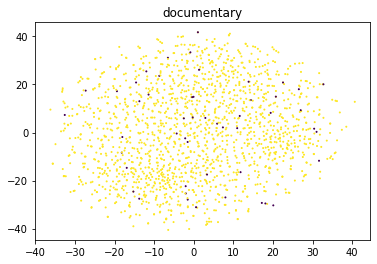

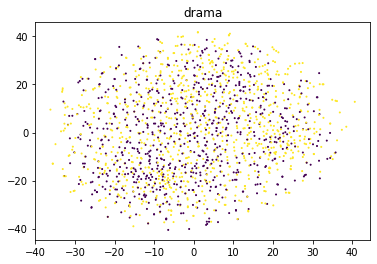

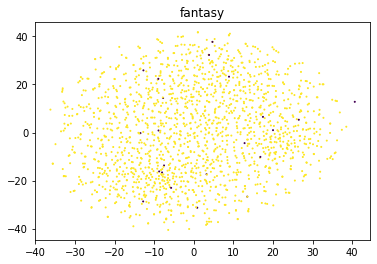

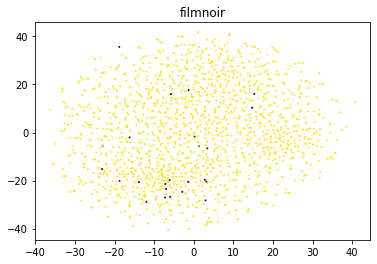

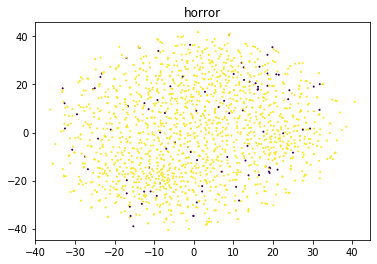

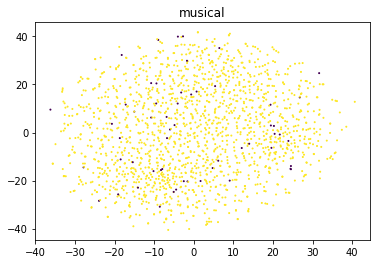

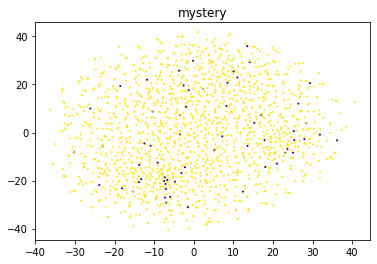

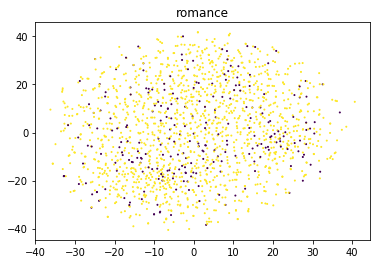

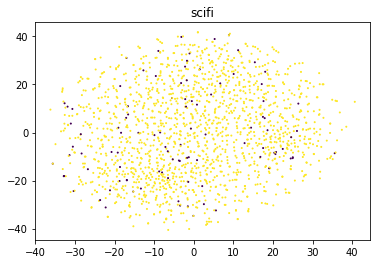

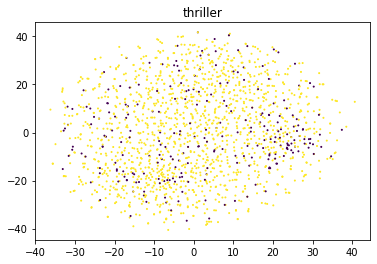

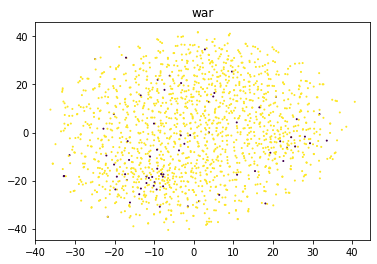

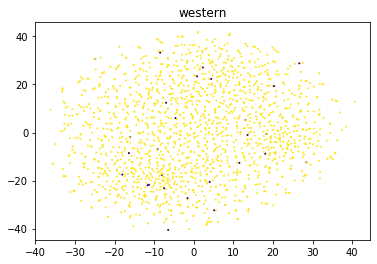

In [11]:
for i in range(19):
    plt.figure()
    plt.title(dGenres.columns[i])
    plt.scatter(tsneMovies[:,0], tsneMovies[:,1], s=1, c=-dGenres.iloc[:,i])

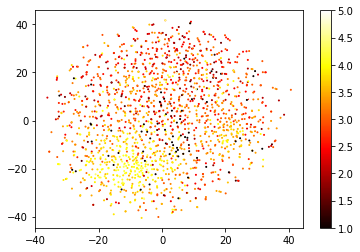

In [12]:
plt.scatter(tsneMovies[:,0], tsneMovies[:,1], s=1, c=dMovies["movieavg"], cmap="hot")
plt.colorbar()